In [20]:
import sys
sys.path.append('../')
import numpy as np
import torch
import os
import pandas as pd
import pydicom
import random
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.nn.functional import interpolate
from skimage.color import rgb2gray, gray2rgb
from lib.dataloading.mapping_dict import *
from sklearn.preprocessing import MultiLabelBinarizer
from lib.preprocessing.single_transforms import get_transformer_norm


In [63]:
def tensor2numpy(img):
    img = np.rollaxis(np.squeeze(img.detach().numpy()), 0 ,3)
    img = (img - np.min(img))/(np.max(img) - np.min(img))
    return img

def combine_numpy(img, center):
    img[64:192, 100:300, :] = center
    return img

def combine_tensor(img, center):
    img[:,:,64:192, 100:300] = center
    return img

def show_img(img, center):
    img = combine_tensor(img, center)
    return tensor2numpy(img)

In [64]:
class SSIDataset(Dataset):    
    
    def __init__(self, img_file, rel_path = "" , shuffle = True, list_id = None, transform = None, inpaint = True, rand_init = None, output_resize = False, rand_shift = False):   
        
        self.df = pd.read_csv(img_file)        
        self.data_path = rel_path
        self.indices = np.arange(self.df.shape[0])
        self.transform = transform
        self.inpaint = inpaint
        self.probe = self.df.Probe.map(probe_dict)        
        self.study_binarize = self._binarize_study(self.df.Study.map(study_dict))
        self.rand_init = rand_init
        self.rand_shift = rand_shift
        self.output_resize = output_resize

        if shuffle == True:            
            np.random.shuffle(self.indices)                        
        
        if list_id != None:
            self.indices = self.indices[list_id]                        
    
    def __len__(self):
        return len(self.indices)
    
    def _get_coord(self, ds):
        coord = ds.SequenceOfUltrasoundRegions[0]
        return coord.RegionLocationMaxX1, coord.RegionLocationMinX0, coord.RegionLocationMaxY1, coord.RegionLocationMinY0
    
    def _inpaint(self, img, is_tensor = True):
        if is_tensor:
            w,h = img.shape[1], img.shape[2]
            if self.rand_shift:
                w_shift = random.randint(-w//8, w//8)
                h_shift = random.randint(-h//8, h//8)
            else:
                w_shift, h_shift = 0
            
            
            label = img[:, w_shift+w//4:w_shift+(w*3)//4, h_shift+h//4:h_shift+(h*3)//4].clone()
            img[0,w_shift+w//4:w_shift+(w*3)//4, h_shift+h//4:h_shift+(h*3)//4] = img[0,:, :].min()            
            img[1,w_shift+w//4:w_shift+(w*3)//4, h_shift+h//4:h_shift+(h*3)//4] = img[1,:, :].min()             
            img[2,w_shift+w//4:w_shift+(w*3)//4, h_shift+h//4:h_shift+(h*3)//4] = img[2,:, :].min()
            
            if self.rand_init == 'gaussian':
                img[0,w_shift+w//4:w_shift+(w*3)//4, h_shift+h//4:h_shift+(h*3)//4] += torch.randn_like(img[0,w_shift+w//4:w_shift+(w*3)//4, h_shift+h//4:h_shift+(h*3)//4])
                img[1,w_shift+w//4:w_shift+(w*3)//4, h_shift+h//4:h_shift+(h*3)//4] += torch.randn_like(img[1,w_shift+w//4:w_shift+(w*3)//4, h_shift+h//4:h_shift+(h*3)//4])
                img[2,w_shift+w//4:w_shift+(w*3)//4, h_shift+h//4:h_shift+(h*3)//4] += torch.randn_like(img[2,w_shift+w//4:w_shift+(w*3)//4, h_shift+h//4:h_shift+(h*3)//4])
            elif self.rand_init == 'uniform':
                img[0,w_shift+w//4:w_shift+(w*3)//4, h_shift+h//4:h_shift+(h*3)//4] += torch.rand_like(img[0,w_shift+w//4:w_shift+(w*3)//4, h_shift+h//4:h_shift+(h*3)//4]) *2 - 1
                img[1,w_shift+w//4:w_shift+(w*3)//4, h_shift+h//4:h_shift+(h*3)//4] += torch.rand_like(img[1,w_shift+w//4:w_shift+(w*3)//4, h_shift+h//4:h_shift+(h*3)//4]) *2 - 1
                img[2,w_shift+w//4:w_shift+(w*3)//4, h_shift+h//4:h_shift+(h*3)//4] += torch.rand_like(img[2,w_shift+w//4:w_shift+(w*3)//4, h_shift+h//4:h_shift+(h*3)//4]) *2 - 1
            return img, label
        else:
            w, h = img.shape[0], img.shape[1]
            img[w//4:(w*3)//4, h//4:(h*3)//4, 0] = img[:, :, 0].min()
            img[w//4:(w*3)//4, h//4:(h*3)//4, 1] = img[:, :, 1].min()
            img[w//4:(w*3)//4, h//4:(h*3)//4, 2] = img[:, :, 2].min()
        return img, label
    
    def _binarize_study(self, study):        
        mlb = MultiLabelBinarizer()
        return mlb.fit_transform(study)
    
    def _output_resize(self, center):
        
        return interpolate(center.unsqueeze(0), scale_factor = 2).squeeze(0)
        
  
    
    def _get_labels(self, idx):
        # probe
        probe = torch.tensor([self.probe[idx]], dtype= torch.uint8)
        study = torch.tensor(self.study_binarize[idx], dtype= torch.uint8)
        return torch.cat([probe, study])
    
    def _output_resize(self, center):
        return interpolate(center.unsqueeze(0), scale_factor = 2).squeeze(0)
    
    def __getitem__(self, idx):    
        if self.data_path == "":
            # No data path specific, use the absolute file path
            ds_path = self.df.iloc[idx].Image_Path
        else:
            # Use the relative path as the data path
            ds_path = os.path.join(self.data_path, self.df.iloc[idx].relative_path)
        ds = pydicom.dcmread(ds_path)
        try:
            img = ds.pixel_array
        except Exception as e:
            print(self.files[idx], 'do not have pixel array')
            return None
        
        assert len(img.shape) == 2 or len(img.shape) == 3, 'This is not an 2 or 3-dimension static image'
        if len(img.shape) == 2:            
            img = gray2rgb(img)
        
        try:        
            x1, x0, y1, y0 = self._get_coord(ds)
            img = img[y0:y1, x0:x1,:]
            
        except Exception as e:
            print(self.files[idx], 'do not have coordinate')
            print(e)
            
                  
        if self.transform is not None:
            img = self.transform(img)
        
        if self.inpaint:
            labels = self._get_labels(idx)
            crop_img, center = self._inpaint(img)   
            if self.output_resize:
                center = self._output_resize(center)
            
            return crop_img, center, labels
        else:
            return img


In [120]:
transform =  get_transformer_norm()
dataset = SSIDataset(img_file= '/media/jimmy/224CCF8B4CCF57E5/Data/SSI/ssi.csv', rel_path='/media/jimmy/224CCF8B4CCF57E5/Data/SSI/', transform= transform['val'], inpaint=True, rand_shift = True, rand_init = 'uniform')

In [125]:
i = random.randint(0, len(dataset))
img, center, label= dataset[i]

In [127]:
img.to(img.device)

tensor([[[-0.6159, -0.6159, -0.6159,  ..., -0.6159, -0.6159, -0.6159],
         [-0.6159, -0.6159, -0.6159,  ..., -0.6159, -0.6159, -0.6159],
         [-0.6159, -0.6159, -0.6159,  ..., -0.6159, -0.6159, -0.6159],
         ...,
         [-0.6159, -0.6159, -0.6159,  ..., -0.6159, -0.6159, -0.6159],
         [-0.6159, -0.6159, -0.6159,  ..., -0.6159, -0.6159, -0.6159],
         [-0.6159, -0.6159, -0.6159,  ..., -0.6159, -0.6159, -0.6159]],

        [[-0.6159, -0.6159, -0.6159,  ..., -0.6159, -0.6159, -0.6159],
         [-0.6159, -0.6159, -0.6159,  ..., -0.6159, -0.6159, -0.6159],
         [-0.6159, -0.6159, -0.6159,  ..., -0.6159, -0.6159, -0.6159],
         ...,
         [-0.6159, -0.6159, -0.6159,  ..., -0.6159, -0.6159, -0.6159],
         [-0.6159, -0.6159, -0.6159,  ..., -0.6159, -0.6159, -0.6159],
         [-0.6159, -0.6159, -0.6159,  ..., -0.6159, -0.6159, -0.6159]],

        [[-0.6159, -0.6159, -0.6159,  ..., -0.6159, -0.6159, -0.6159],
         [-0.6159, -0.6159, -0.6159,  ..., -0

In [122]:
img = tensor2numpy(img)

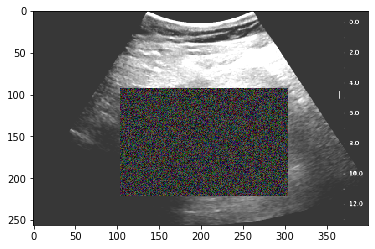

In [123]:
plt.imshow(img)

In [4]:
root = '../../Data/SSI/'
local_path = [os.path.join(root, f'image{i}')for i in range(12267)]

In [5]:
ssi.Image_Path = pd.Series(local_path)

In [6]:
ssi.columns

Index(['Unnamed: 0', 'ACC', 'Image_Path', 'Study', 'Series', 'Probe'], dtype='object')

In [7]:
new_ssi = ssi.drop(['Unnamed: 0'], axis = 1)
new_ssi = new_ssi.drop(7767)

In [8]:
new_ssi.to_csv('../../../Data/SSI/ssi.csv', index = None)

In [9]:
new_ssi

,ACC,Image_Path,Study,Series,Probe
0,E11314299,../../Data/SSI/image0,US PARACENTESIS DIAGNOSTIC,Abdomen/Breast,SC6-1
1,E11314299,../../Data/SSI/image1,US PARACENTESIS DIAGNOSTIC,Abdomen/Breast,SC6-1
2,E11314299,../../Data/SSI/image2,US PARACENTESIS DIAGNOSTIC,Abdomen/Breast,SL10-2
3,E13139682,../../Data/SSI/image3,US PARACENTESIS DIAGNOSTIC,Abdomen/Breast,SL10-2
4,E13139682,../../Data/SSI/image4,US PARACENTESIS DIAGNOSTIC,Abdomen/Breast,SL10-2
...,...,...,...,...,...
12262,E12848115,../../Data/SSI/image12262,US LYMPH NODE BIOPSY,Up Ext Venous,SL10-2
12263,E12848115,../../Data/SSI/image12263,US LYMPH NODE BIOPSY,Up Ext Venous,SL10-2
12264,E12848115,../../Data/SSI/image12264,US LYMPH NODE BIOPSY,Up Ext Venous,SL10-2
12265,E12848115,../../Data/SSI/image12265,US LYMPH NODE BIOPSY,Up Ext Venous,SL10-2


In [13]:
for i in range(len(dataset)):
    try:
        img = dataset[i]
    except:
        print(i)

7767


In [14]:
ssi = pd.read_csv('../../../Data/SSI/ssi.csv')

In [17]:
ssi.drop(7767)

,ACC,Image_Path,Study,Series,Probe
0,E11314299,../../../Data/SSI/image0,US PARACENTESIS DIAGNOSTIC,Abdomen/Breast,SC6-1
1,E11314299,../../../Data/SSI/image1,US PARACENTESIS DIAGNOSTIC,Abdomen/Breast,SC6-1
2,E11314299,../../../Data/SSI/image2,US PARACENTESIS DIAGNOSTIC,Abdomen/Breast,SL10-2
3,E13139682,../../../Data/SSI/image3,US PARACENTESIS DIAGNOSTIC,Abdomen/Breast,SL10-2
4,E13139682,../../../Data/SSI/image4,US PARACENTESIS DIAGNOSTIC,Abdomen/Breast,SL10-2
...,...,...,...,...,...
12262,E12848115,../../../Data/SSI/image12262,US LYMPH NODE BIOPSY,Up Ext Venous,SL10-2
12263,E12848115,../../../Data/SSI/image12263,US LYMPH NODE BIOPSY,Up Ext Venous,SL10-2
12264,E12848115,../../../Data/SSI/image12264,US LYMPH NODE BIOPSY,Up Ext Venous,SL10-2
12265,E12848115,../../../Data/SSI/image12265,US LYMPH NODE BIOPSY,Up Ext Venous,SL10-2
